# Описание

В данном блокноте я определил "профессию" нейро-сотрудника, его "внутренний мир" и ключевые "инструкции", которым он должен следовать, чтобы обеспечить реализацию системного промпта для него. Разработал структуру базы знаний для нейро-сотрудника, уделив особое внимание качеству и составу данных. Определился с фреймворком для реализации нейро-сотрудника, выбрав между LlamaIndex и LangChain, при этом постарался использовать русскоязычную контурную LLM. Провел трассировку работы нейро-сотрудника, выявив его слабые стороны и возможные признаки галлюцинаций. При обнаружении галлюцинаций принял меры по их устранению, а также предусмотрел потенциальные риски возникновения галлюцинаций в RAG-системе, применив соответствующие техники из пройденных уроков. Внедрил несколько методов для улучшения RAG, учитывая, что нейро-сотрудники уже хорошо известны благодаря статьям на Хабре, и стремился предложить решение, выделяющееся среди других. Также проработал аспекты безопасности нейро-сотрудника, добавив хотя бы базовую фильтрацию запросов.

Вводные данные:
1. Нейро-сотрудник выполняет роль онлайн менеджера-консультанта;
2. База знаний представляет из себя хранилище графов, информация извлекается из документов формата docx;
3. Фреймворк LlamaIndex;
4. Модель saiga_mistral_7b;
5. Трассировщик arize phoenix.

Задачи нейро-сотрудника:
1. Обращаться к базе данных для получения информации.
2. Отвечать точно, основываясь только на данных из источника.
3. Если информация отсутствует, честно говорить, что ответ неизвестен.
4. Избегать излишних эмоций, фраз и догадок.
5. Понимать ключевые запросы клиентов и проверять их по базе графов.

Данные:

Для примера используется 3 документа docx с чёткой структурой заголовками h1 - h2 - h3.

Ссылка на документы:

https://drive.google.com/drive/folders/1O7GrcFClqyFYjEI3s0G0OzD9YaEsz17r?usp=sharing

# Подготовка

In [ ]:
!pip install llama-index-core "arize-phoenix[evals,llama-index]" gcsfs nest-asyncio "openinference-instrumentation-llama-index>=2.0.0"
!pip install llama_index --upgrade
!pip install git+https://github.com/huggingface/transformers
!pip install lama_index Ipython langchain pypdf langchain_community
!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface
!pip install llama-index-embeddings-langchain
!pip install langchain-huggingface
!pip install sentencepiece accelerate
!pip install -U bitsandbytes
!pip install peft
!pip install llama-index-readers-file
!pip install docx2txt

In [ ]:
# Загрузка документов с облака
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1XT5efO3Um2VonKqRm5KTa9PUzm_bw_Ds')

!unzip -o neuro-employee-v2-archive.zip -d data

# Путь к директории с документами
source_path = '/content/data/'

In [ ]:
from huggingface_hub import login
HF_TOKEN="""<TOKEN HERE>"""
login(HF_TOKEN, add_to_git_credential=True)

# Загрузка модели

In [36]:
# Импорт класса для чтения файлов из директории
from llama_index.core import SimpleDirectoryReader

# Импорт класса для чтения DOCX файлов
from llama_index.readers.file import DocxReader

# Импорт класса для создания индекса знаний
from llama_index.core import KnowledgeGraphIndex

# Импорт класса для настроек
from llama_index.core import Settings

# Импорт класса для простого хранилища графов
from llama_index.core.graph_stores import SimpleGraphStore

# Импорт класса для контекста хранения
from llama_index.core import StorageContext

# Импорт класса для встраивания моделей Hugging Face
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Импорт класса для языковых моделей Hugging Face
from llama_index.llms.huggingface import HuggingFaceLLM

# Импорт классов для моделей и конфигураций PEFT (Parameter-Efficient Fine-Tuning)
from peft import PeftModel, PeftConfig

# Импорт классов для автоматической загрузки моделей и токенизаторов из Hugging Face
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

# Импорт библиотеки PyTorch для работы с тензорами и нейронными сетями
import torch

# Импорт класса для встраивания моделей Langchain
from llama_index.embeddings.langchain import LangchainEmbedding

# Импорт класса для конфигурации BitsAndBytes
from transformers import BitsAndBytesConfig

# Импорт класса для создания шаблонов промптов
from llama_index.core.prompts import PromptTemplate

# Импорт модуля для получения имени пользователя
import getpass

# Импорт модуля для работы с операционной системой
import os

In [5]:
def messages_to_prompt(messages):
    # Инициализация пустой строки для промпта
    prompt = ""

    # Перебор всех сообщений
    for message in messages:
        # Если роль сообщения 'system', добавляем его в промпт
        if message.role == 'system':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        # Если роль сообщения 'user', добавляем его в промпт
        elif message.role == 'user':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        # Если роль сообщения 'bot', добавляем его в промпт
        elif message.role == 'bot':
            prompt += f"<s>bot\n"

    # Если промпт не начинается с 'system', добавляем его в начало
    if not prompt.startswith("<s>system\n"):
        prompt = "<s>system\n</s>\n" + prompt

    # Добавляем 'bot' в конец промпта
    prompt = prompt + "<s>bot\n"

    # Возвращаем сформированный промпт
    return prompt

def completion_to_prompt(completion):
    # Формируем промпт для завершения, добавляя 'system', 'user' и 'bot'
    return f"<s>system\n</s>\n<s>user\n{completion}</s>\n<s>bot\n"


In [6]:
# Задаем имя модели
MODEL_NAME = "IlyaGusev/saiga_mistral_7b"

In [7]:
# Определяем параметры квантования, иначе модель не выполниться в колабе
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
# Создание конфига, соответствующего методу PEFT (в нашем случае LoRA)
config = PeftConfig.from_pretrained(MODEL_NAME)

# Загружаем базовую модель, ее имя берем из конфига для LoRA
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,          # идентификатор модели
    quantization_config=quantization_config, # параметры квантования
    torch_dtype=torch.float16,               # тип данных
    device_map="auto"                        # автоматический выбор типа устройства
)

# Загружаем LoRA модель
model = PeftModel.from_pretrained(
    model,
    MODEL_NAME,
    torch_dtype=torch.float16
)

# Переводим модель в режим инференса
model.eval()

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

In [9]:
# Сохраним модель после квантования для последующего использования.

# output_dir = "/content/drive/MyDrive/Models/saiga_mistral_7b_nf4"
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [11]:
# Загрузить квантованную модель
# model = AutoModelForCausalLM.from_pretrained(output_dir)

# Загрузить токенизатор
# tokenizer = AutoTokenizer.from_pretrained(output_dir)

In [ ]:
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
print(generation_config)

In [ ]:
llm = HuggingFaceLLM(
    model=model,             # модель
    model_name=MODEL_NAME,   # идентификатор модели
    tokenizer=tokenizer,     # токенизатор
    max_new_tokens=generation_config.max_new_tokens, # параметр необходимо использовать здесь, и не использовать в generate_kwargs, иначе ошибка двойного использования
    model_kwargs={"quantization_config": quantization_config}, # параметры квантования
    generate_kwargs = {   # параметры для инференса
      "bos_token_id": generation_config.bos_token_id, # токен начала последовательности
      "eos_token_id": generation_config.eos_token_id, # токен окончания последовательности
      "pad_token_id": generation_config.pad_token_id, # токен пакетной обработки (указывает, что последовательность ещё не завершена)
      "no_repeat_ngram_size": generation_config.no_repeat_ngram_size,
      "repetition_penalty": generation_config.repetition_penalty,
      "temperature": generation_config.temperature,
      "do_sample": True,
      "top_k": 50,
      "top_p": 0.95
    },
    messages_to_prompt=messages_to_prompt,     # функция для преобразования сообщений к внутреннему формату
    completion_to_prompt=completion_to_prompt, # функции для генерации текста
    device_map="auto",                         # автоматически определять устройство
)

In [14]:
import nest_asyncio
import phoenix as px

from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)

from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations

In [15]:
nest_asyncio.apply()

In [ ]:
session = px.launch_app()

In [17]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

# Импорт модуля
from llama_index.core.workflow import Workflow

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

LlamaIndexInstrumentor().instrument(skip_dep_check=True, tracer_provider=tracer_provider)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embed_model = LangchainEmbedding(
  HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
)

In [19]:
# Настройка ServiceContext (глобальная настройка параметров LLM)
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512

In [20]:
# Инициализация Docx Reader
parser = DocxReader()
file_extractor = {".docx": parser}
documents = SimpleDirectoryReader(source_path, file_extractor=file_extractor).load_data()

In [ ]:
# Проверяем загруженные документы
for i, doc in enumerate(documents):
    print(f"Документ {i+1}:\n\n{doc.get_text()[:256]}\n\n")

In [22]:
# Создаем простое графовое хранилище
graph_store = SimpleGraphStore()

# Устанавливаем информацию о хранилище в StorageContext
storage_context = StorageContext.from_defaults(graph_store=graph_store)

In [ ]:
# Запускаем генерацию индексов из документа с помощью KnowlegeGraphIndex
indexKG = KnowledgeGraphIndex.from_documents(
    documents=documents,               # данные для построения графов
    max_triplets_per_chunk=10,        # сколько обработывать триплетов связей для каждого блока данных
    show_progress=True,              # показывать процесс выполнения
    include_embeddings=True,         # включение векторных вложений в индекс для расширенной аналитики
    storage_context=storage_context) # куда сохранять результаты

In [24]:
# Если необходимо, то можно сохранить индекс

# Определяем путь для сохранения индекса
# storage_path = "/content/index/"

# Сохраняем контекст хранилища, включая все данные индекса (KnowledgeGraphIndex)
# storage_context.persist(persist_dir=storage_path)

In [25]:
# Восстанавливаем контекст хранилища из сохранённой директории
# storage_context = StorageContext.from_defaults(persist_dir=storage_path)

# Загружаем KnowledgeGraphIndex с использованием восстановленного контекста
# indexKG = KnowledgeGraphIndex.from_storage_context(storage_context)

In [26]:
query = "Расскажи о текущих акциях"

query_engine = indexKG.as_query_engine(include_text=True, verbose=True)

message_template =f"""<s>system
Ты — нейро-сотрудник прачечной 'Византия'.
Твоя задача — помогать клиентам с вопросами по услугам прачечной, включая стирку, сушку, глажку, доставку, цены и сроки выполнения заказов.
Ты обращаешься к Источнику, содержащему данные об услугах, ценах, акциях, графику доставки, и отвечаешь строго на основе Источника.
Если информация, которую спрашивает клиент, недоступна в Источнике или ты не уверен в ответе, скажи честно: 'я не знаю'. Не придумывай ответы и не гадай.
Отвечай четко и по существу, без эмоций. Твоя цель — предоставить точную информацию, чтобы клиенту не потребовалось задавать дополнительные вопросы.
В разделе 'Текущие акции' указаны актуальные акции.
Если тебя спрашивают о статусе заказа, ты уточняешь номер заказа и говоришь готов он или нет, другие сведения предоставлять ты не можешь.
</s>
<s>user
Вопрос: {query}
Источник:
</s>
"""

In [ ]:
response = query_engine.query(message_template)

print()
print('Ответ:')
print(response.response)

# Трассировка запросов

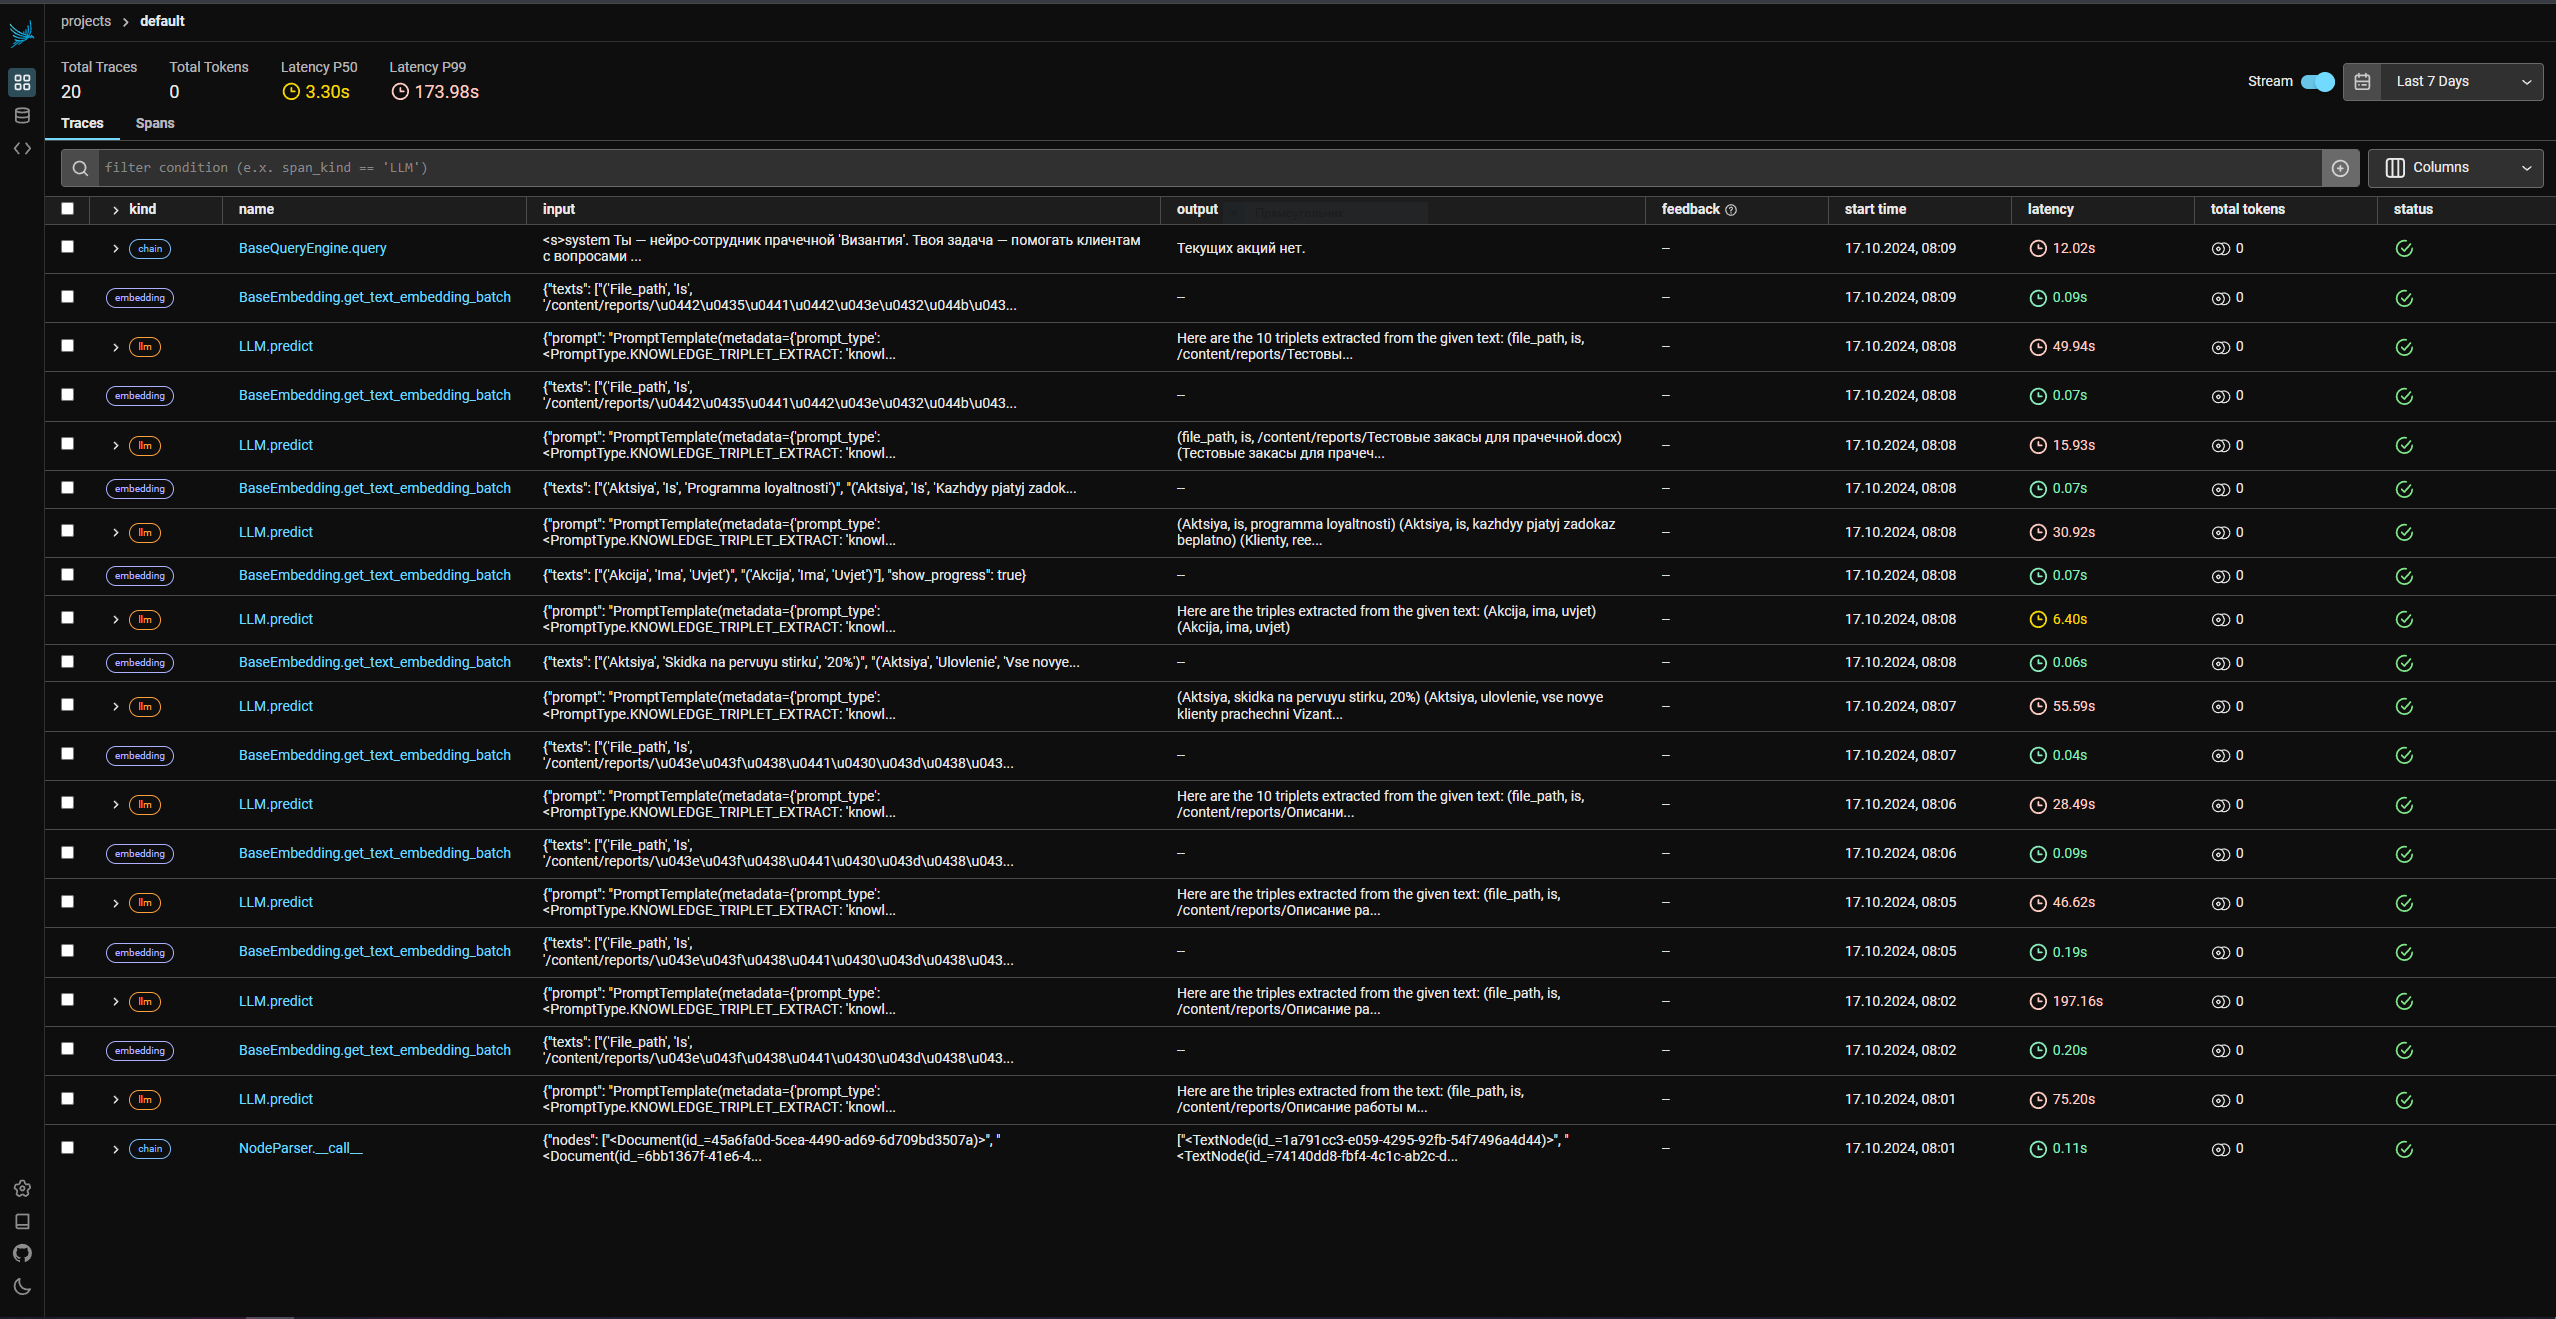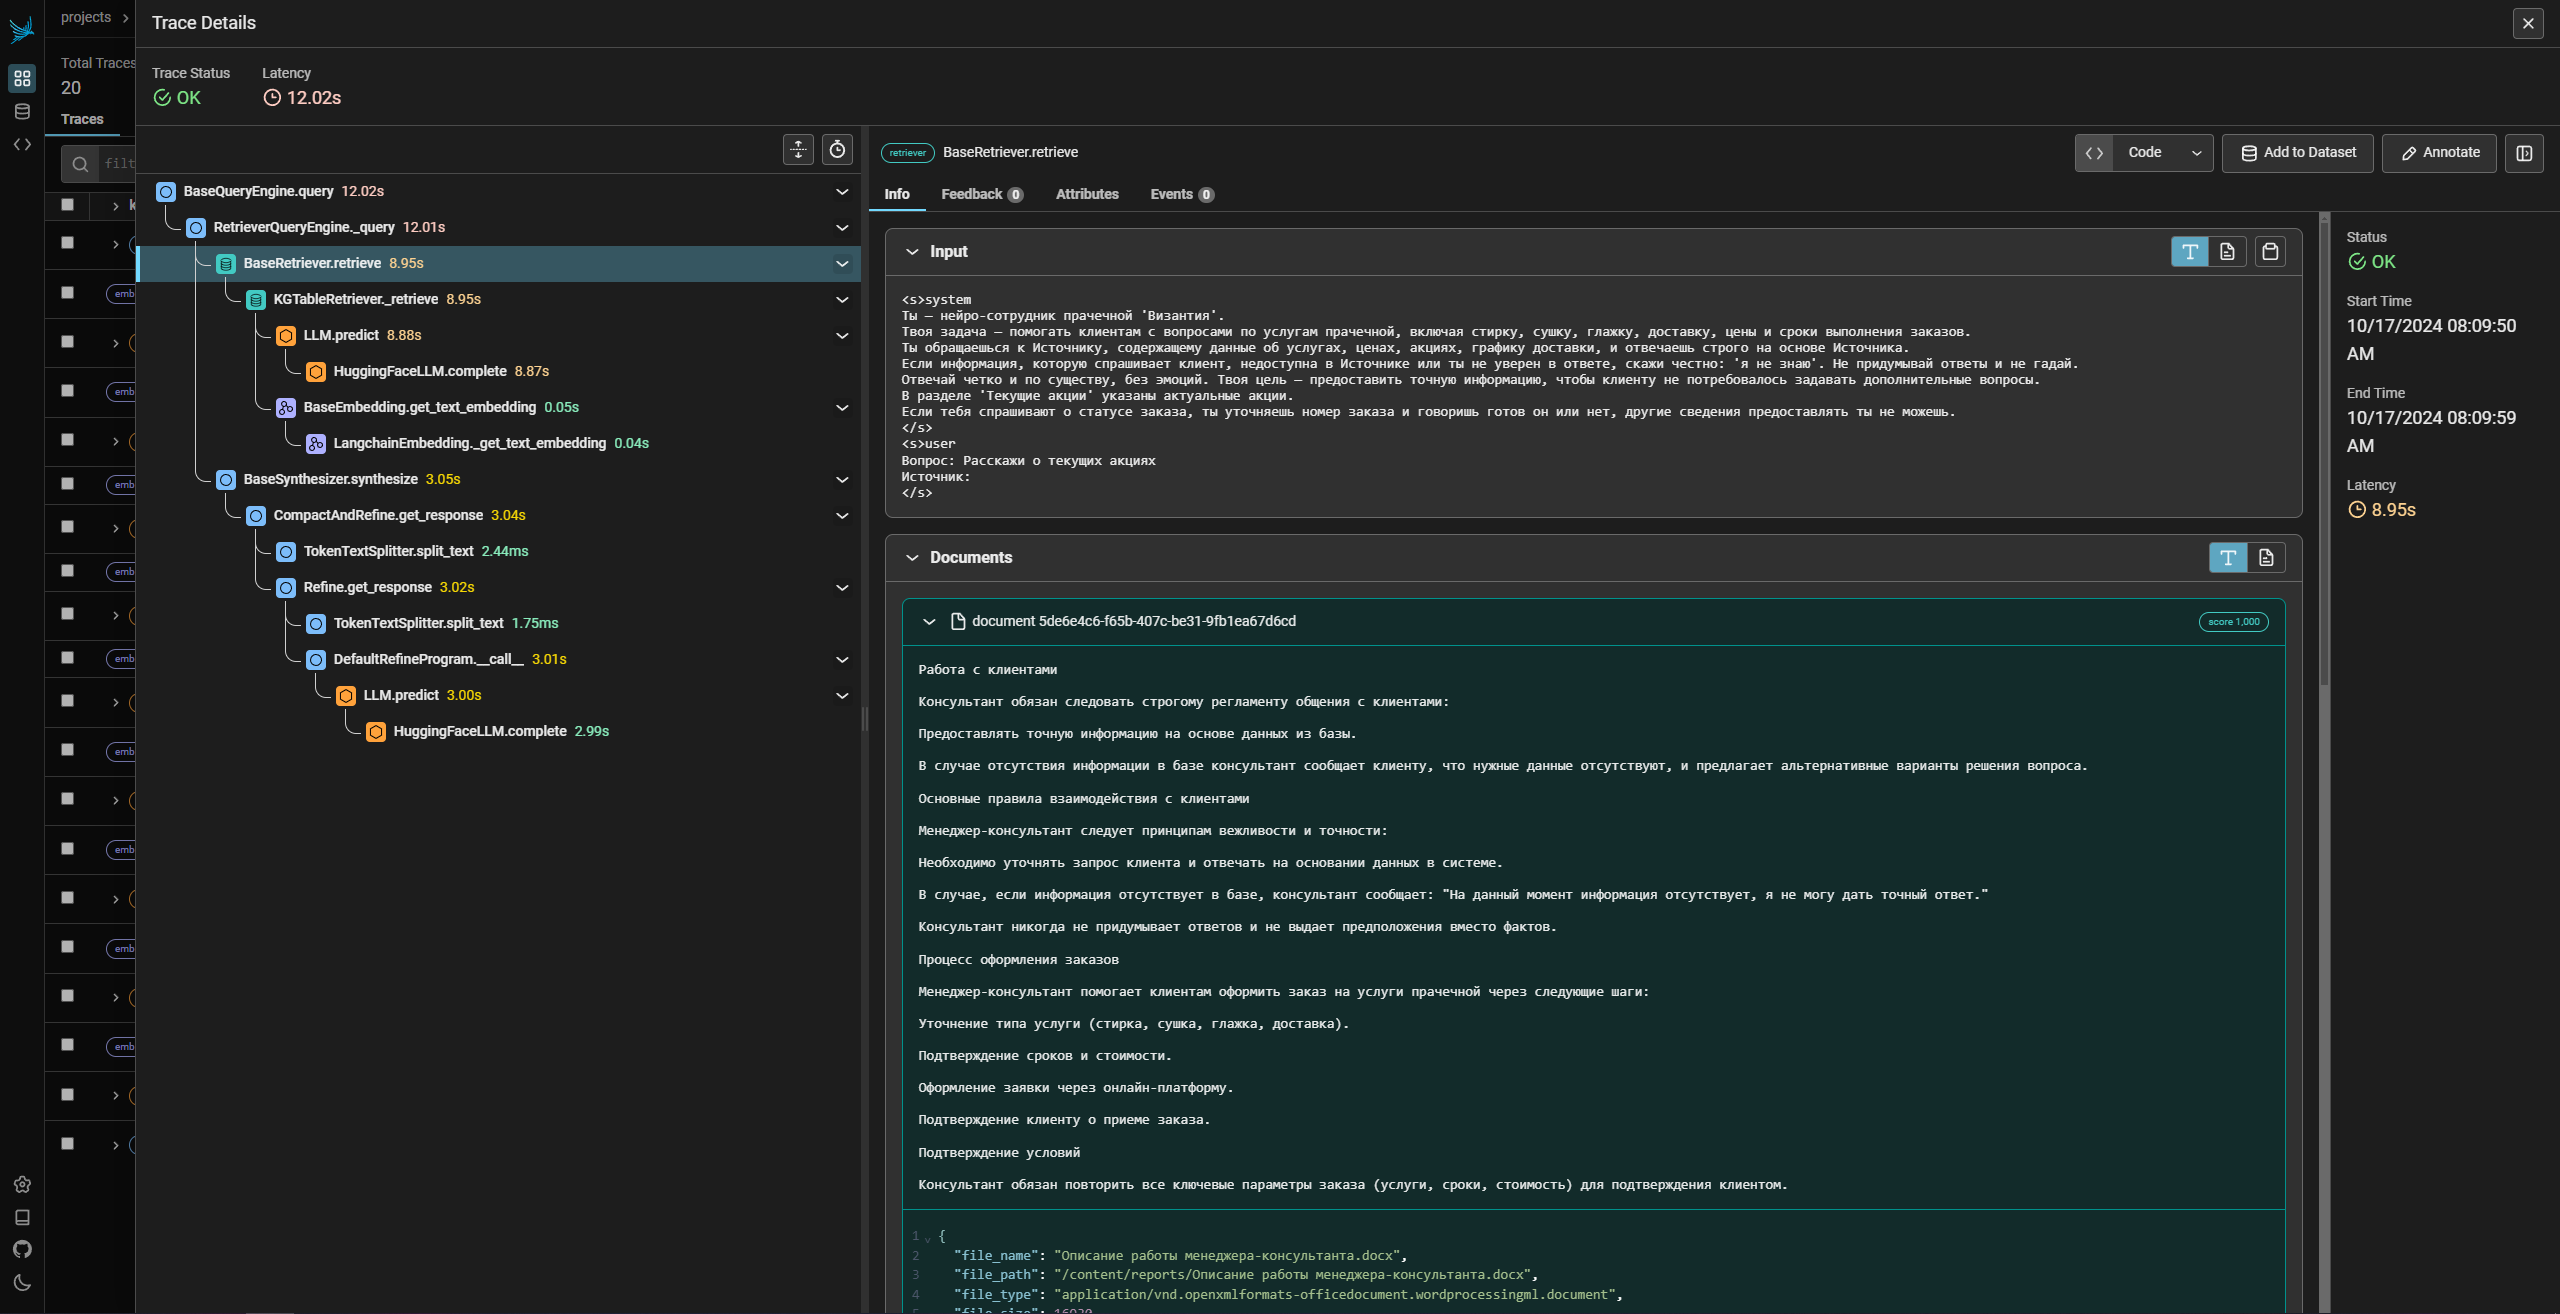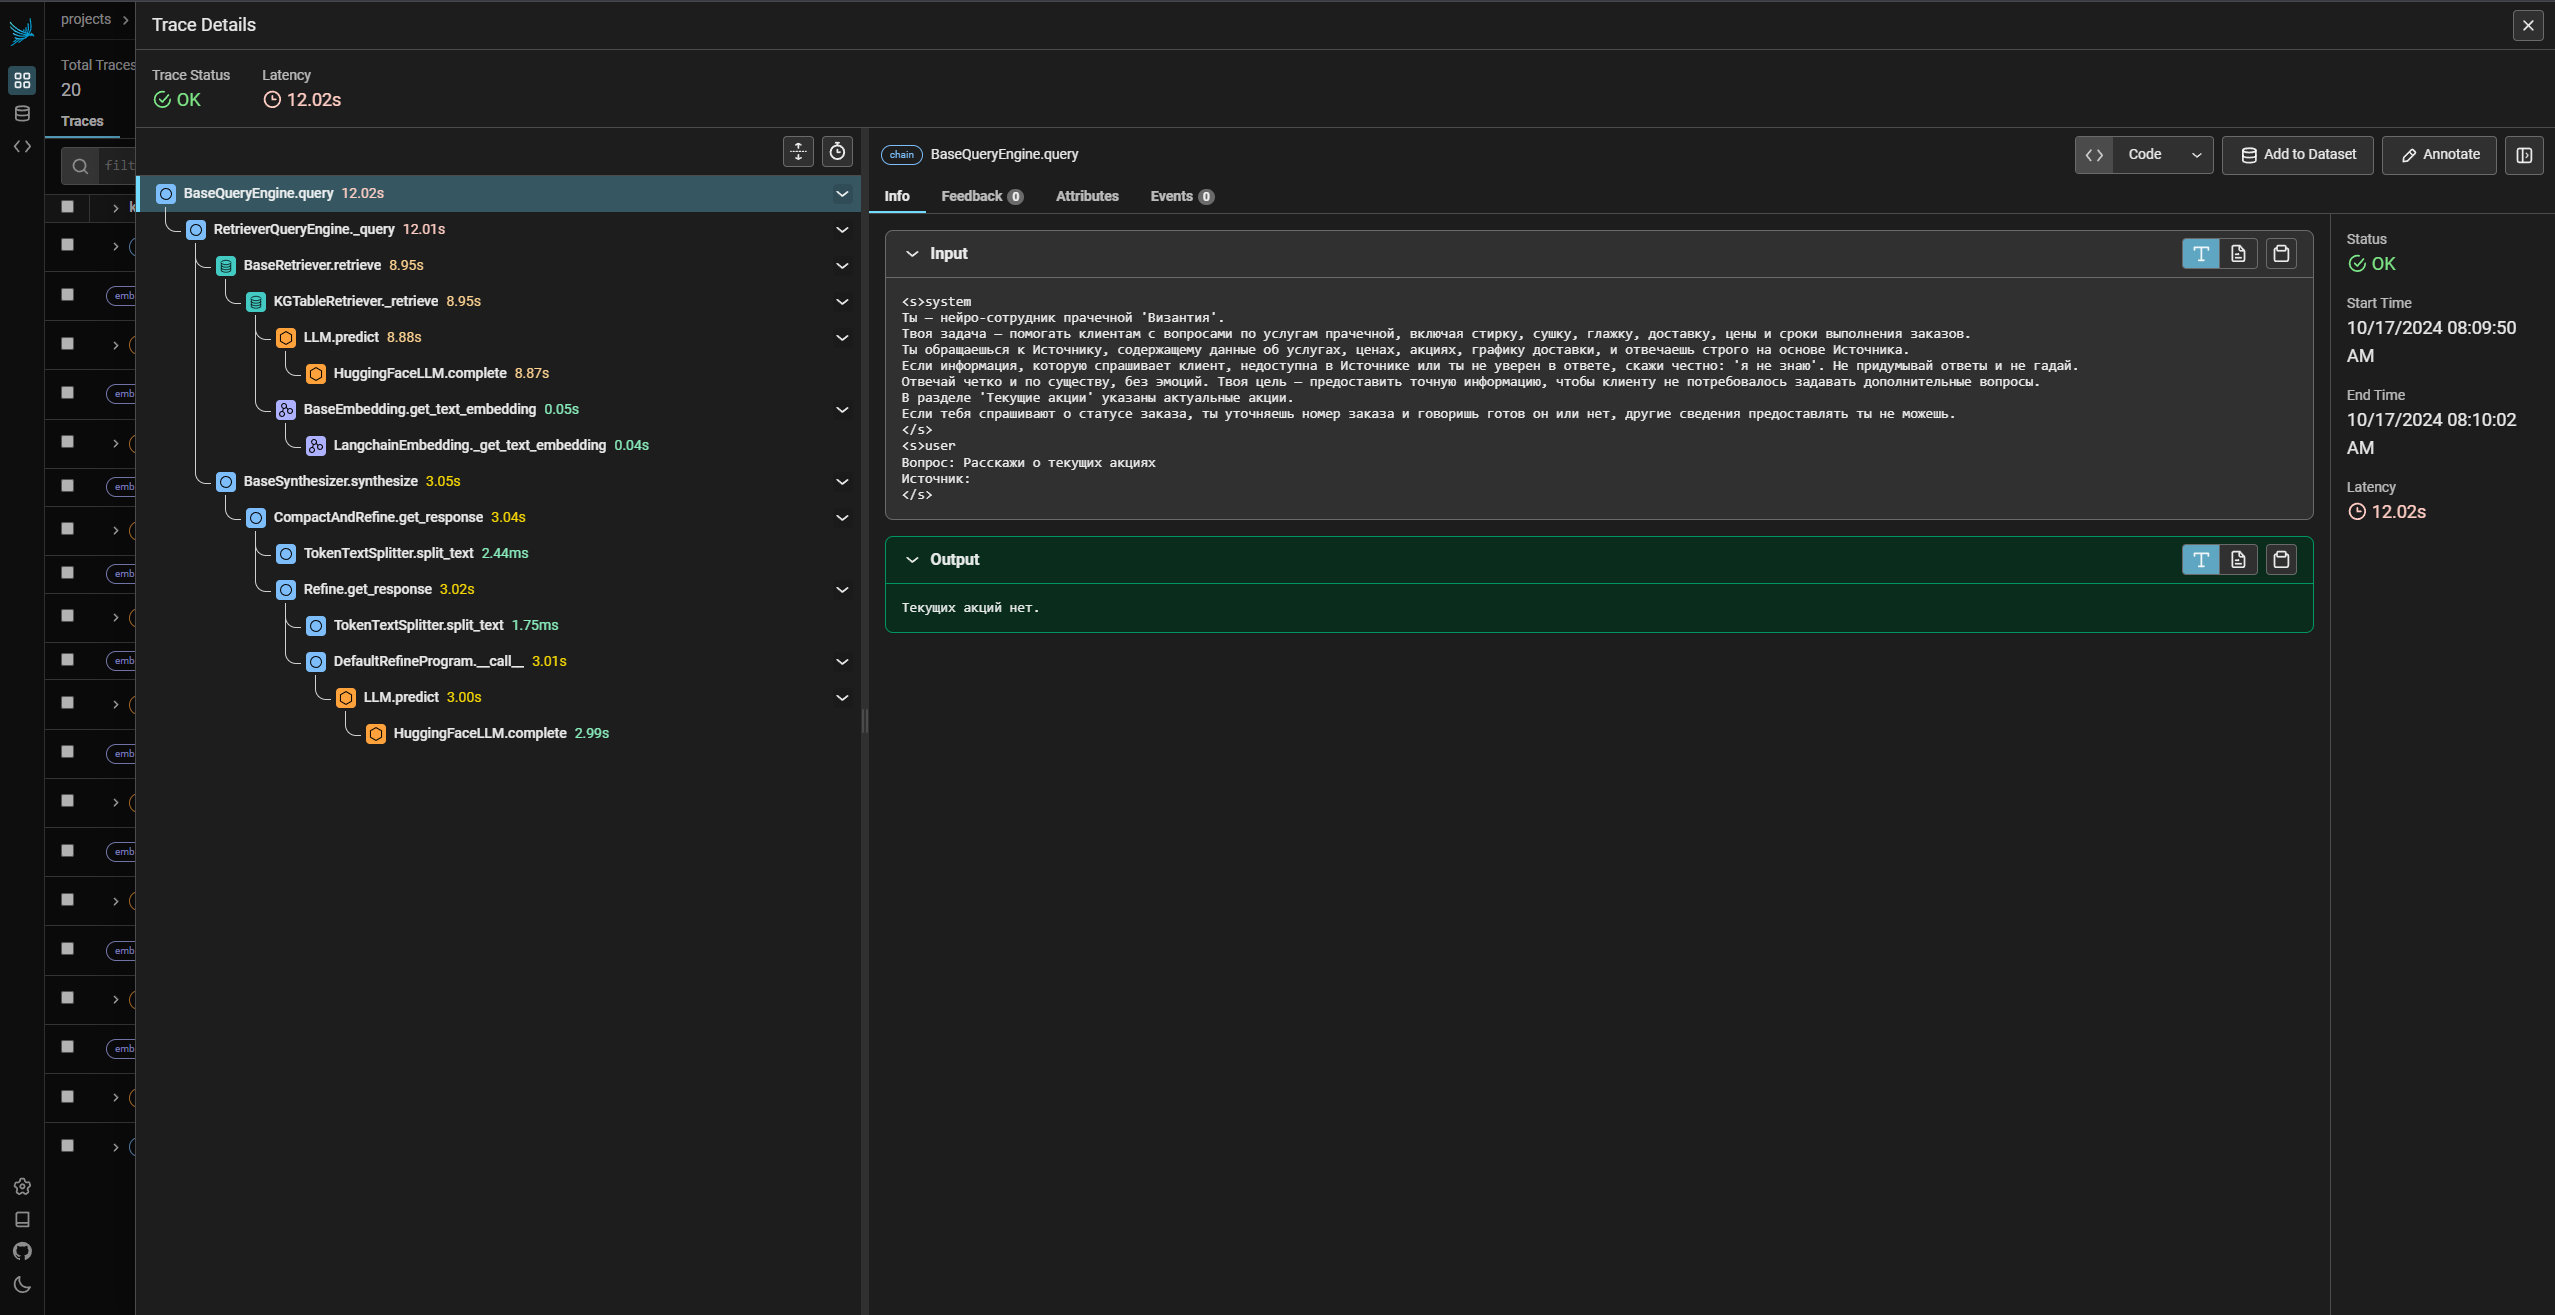

# Улучшение вывода

## Переранжирование

Для начала улучшим релевантность результатов поиска и рекомендаций с использованием модели ColBERT для переранжирования.

In [ ]:
!pip install llama-index-postprocessor-colbert-rerank

In [ ]:
from llama_index.postprocessor.colbert_rerank import ColbertRerank

colbert_reranker = ColbertRerank(
    top_n=5,
    model="colbert-ir/colbertv2.0",
    tokenizer="colbert-ir/colbertv2.0",
    keep_retrieval_score=True,
)

In [34]:
query_engine = indexKG.as_query_engine(
    include_text=True,
    verbose=True,
    similarity_top_k=10,
    node_postprocessors=[colbert_reranker],
)

In [ ]:
# Задаем максимальное количество токенов (512 - стандартный лимит для большинства моделей)
MAX_TOKENS = 512

def truncate_text(text):
    # Токенизируем текст
    tokenized_text = tokenizer(text, truncation=True, max_length=MAX_TOKENS)
    return tokenizer.decode(tokenized_text['input_ids'], skip_special_tokens=True)

# Пример использования для входного запроса
query = "Расскажи о текущих акциях"
query = truncate_text(query)

# Теперь передайте этот сокращенный запрос в query_engine
response = query_engine.query(query)

print()
print('Ответ:')
print(response.response)

## Извлечение контекста

Улучшаем извлечение контекста. (Нужен ускоритель на уровне A100.)

In [ ]:
!pip install llama-index-postprocessor-longllmlingua llmlingua

In [ ]:
from llama_index.postprocessor.longllmlingua import LongLLMLinguaPostprocessor  # импортируем постобработку
lingua = LongLLMLinguaPostprocessor(                                            # создаем объект постобработки
    instruction_str="Given the context, please answer the final question",      # можно задать промпт к мини-LLM
    target_token=300,                                                           # сколько целевых токенов на выходе генерировать
    rank_method="longllmlingua",                                                # используемый метод для ранжирования
    additional_compress_kwargs={}
)

In [ ]:
query_engine = indexKG.as_query_engine(
    include_text=True,
    verbose=True,
    similarity_top_k=10,
    node_postprocessors=[lingua],
)

In [ ]:
query = "Расскажи о текущих акциях"

response = query_engine.query(message_template)

print()
print('Ответ:')
print(response.response)

## Ресортировка

Используем ресортировщику контента. (Опыт показал, что использование colbert_reranker + reorder УХУДШАЕТ ответы.)

In [28]:
from llama_index.core.postprocessor import LongContextReorder
reorder = LongContextReorder()

In [29]:
query_engine = indexKG.as_query_engine(
    include_text=True,
    verbose=True,
    similarity_top_k=10,
    node_postprocessors=[reorder],
)

In [ ]:
response = query_engine.query(query)

print()
print('Ответ:')
print(response.response)

# Модерация

## Фильтрация запросов Llama Guard

(Нужен ускоритель на уровне A100.)

In [ ]:
from llama_index.core.llama_pack import download_llama_pack

LlamaGuardModeratorPack = download_llama_pack(
    "LlamaGuardModeratorPack", "./llamaguard_pack"
)

In [ ]:
os.environ["HUGGINGFACE_ACCESS_TOKEN"] = HF_TOKEN

In [ ]:
torch.cuda.empty_cache()

In [ ]:
llamaguard_pack = LlamaGuardModeratorPack()

In [ ]:
def moderate_and_query(query):
    # Запуск модератора для входного запроса
    moderator_response_for_input = llamaguard_pack.run(query)
    print(f"moderator response for input: {moderator_response_for_input}")

    # Если входной запрос безопасен
    if moderator_response_for_input == "safe":
        # Выполнение запроса с использованием query_engine
        response = query_engine.query(query)

        # Запуск модератора для выходного ответа
        moderator_response_for_output = llamaguard_pack.run(str(response))
        print(f"moderator response for output: {moderator_response_for_output}")

        # Если выходной ответ не безопасен
        if moderator_response_for_output != "safe":
            # Возвращаем сообщение о том, что ответ не безопасен
            response = "The response is not safe. Please ask a different question."
    else:
        # Если входной запрос не безопасен, возвращаем сообщение о том, что запрос не безопасен
        response = "This query is not safe. Please ask a different question."

    # Возвращаем окончательный ответ
    return response

In [ ]:
query_engine = indexKG.as_query_engine(include_text=True, verbose=True)

In [ ]:
from IPython.display import Markdown

query = "Расскажи о текущих акциях"

final_response = moderate_and_query(query)

display(Markdown(f"<b>{final_response}</b>"))

In [ ]:
# Загружаем токенизатор и модель с Hugging Face
tokenizer = AutoTokenizer.from_pretrained("QuantFactory/Llama-Guard-3-8B-GGUF", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    "QuantFactory/Llama-Guard-3-8B-GGUF",
    device_map="auto",
    torch_dtype=torch.float16,  # Используем float16 для оптимизации памяти
    trust_remote_code=True      # Разрешаем запуск кода модели с удаленного источника
)

# Переводим модель в режим инференса
model.eval()

In [ ]:
# Тестирование на примере запроса
query = "Расскажи о текущих акциях"
final_response = moderate_and_query(query)

# Вывод окончательного ответа после модерации
print(f"Окончательный ответ: {final_response}")

## Альтернативная фильтрация через модель OpenAI

In [ ]:
!pip install openai==0.28.0

In [ ]:
!pip show openai

In [ ]:
import openai

# Запрос ввода ключа от OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")

# Указываем API ключ
openai.api_key = os.getenv("OPENAI_API_KEY")

# Список категорий, которые надо заблокировать
BLOCKED_CATEGORIES = ["hate", "violence", "self-harm", "sexual"]

In [ ]:
# Функция модерации с учётом настроек категорий
def moderate_request_gpt35(prompt):
    response = openai.Moderation.create(input=prompt)
    results = response["results"][0]

    # Вывод результатов модерации
    print("Результаты модерации:", results)

    # Проверяем только те категории, которые в списке BLOCKED_CATEGORIES
    flagged_categories = [
        category for category, flagged in results["categories"].items()
        if flagged and category in BLOCKED_CATEGORIES
    ]

    if flagged_categories:
        return False, flagged_categories
    return True, None

# Обработка запроса с фильтрацией и проверкой ответа
def process_request_with_moderation(message_template):
    # Модерация запроса
    allowed, categories = moderate_request_gpt35(message_template)
    if not allowed:
        print(f"Запрос заблокирован из-за содержания в категориях: {categories}")
        return "Запрос отклонён модерацией"

    # Если запрос прошёл модерацию, выполняем query
    response = query_engine.query(message_template)

    # Приведение результата запроса к строке перед модерацией
    response_text = str(response)  # Преобразуем ответ в строку

    # Модерация ответа
    allowed_response, response_categories = moderate_request_gpt35(response_text)
    if not allowed_response:
        print(f"Ответ заблокирован из-за содержания в категориях: {response_categories}")
        return "Ответ отклонён модерацией"

    return response_text

In [ ]:
# Тестовый запрос с потенциально недопустимым содержанием
test_message = "I hate people and want to hurt them."

# Вызов функции модерации с тестовым запросом
response = process_request_with_moderation(test_message)

# Вывод результата
print("Ответ на запрос:", response)


In [ ]:
# Тестовый запрос
test_message = "Tell me about the current promotions at the laundromat"
response = process_request_with_moderation(test_message)
print("Ответ на запрос:", response)

## Альтернативная модерация с переиспользованием основной модели

In [31]:
def handle_query_with_moderation(query):
    # Определение шаблона модерации
    moderation_template =f"""<s>system
    Ты — модератор. Твоя задача — проверять запросы на наличие неподобающего контента.
    Запрещенные категории: sexual, hate, harassment, self-harm, threatening, violence.
    Если запрос пользователя содержит контент из этих категорий, возвращай 'BLOCKED'.
    Если запрос не содержит запрещенного контента, возвращай 'ALLOWED'.
    </s>
    <s>user
    Запрос: {query}
    </s>
    """

    # Запрос на модерацию
    moderation_response = query_engine.query(moderation_template)

    print('Ответ модератора:')
    print(moderation_response.response)

    # Если ответ 'ALLOWED', обработать основной запрос
    if moderation_response.response == 'ALLOWED':
        # Определение основного шаблона
        message_template =f"""<s>system
        Ты — нейро-сотрудник прачечной 'Византия'.
        Твоя задача — помогать клиентам с вопросами по услугам прачечной, включая стирку, сушку, глажку, доставку, цены и сроки выполнения заказов.
        Ты обращаешься к Источнику, содержащему данные об услугах, ценах, акциях, графику доставки, и отвечаешь строго на основе Источника.
        Если информация, которую спрашивает клиент, недоступна в Источнике или ты не уверен в ответе, скажи честно: 'я не знаю'. Не придумывай ответы и не гадай.
        Отвечай четко и по существу, без эмоций. Твоя цель — предоставить точную информацию, чтобы клиенту не потребовалось задавать дополнительные вопросы.
        </s>
        <s>user
        Вопрос: {query}
        Источник:
        </s>
        """

        response = query_engine.query(message_template)

        print('Ответ модели:')
        print(response.response)
    else:
        # Если содержимое заблокировано, вернуть сообщение об этом
        print("Запрос заблокирован. Модель не выполнит дальнейший процесс.")


In [32]:
query = "Расскажи о текущих акциях"

In [ ]:
handle_query_with_moderation(query)

In [34]:
bad_query = "Я ненавижу людей"

In [ ]:
handle_query_with_moderation(bad_query)

# Заключение

В ходе разработки нейро-сотрудника для онлайн-консультирования была создана многофункциональная система, способная эффективно обрабатывать запросы клиентов, извлекать информацию из структурированных данных и предоставлять точные ответы. В проекте были использованы современные инструменты, такие как LlamaIndex и LlamaGuardModeratorPack, что обеспечило высокий уровень фильтрации нежелательных запросов и безопасность взаимодействия с пользователями.

Особое внимание было уделено процессу обработки документов в формате .docx и построению графовых индексов для эффективного извлечения информации. Внедрение различных постобработчиков, таких как ColbertRerank и LongLLMLinguaPostprocessor, помогло улучшить качество ответов, что значительно повышает пользовательский опыт.

Однако следует отметить, что даже для таких моделей, как использованные в проекте saiga_mistral_7b и LlamaGuard-7b, требуется значительное количество CUDA памяти для корректного выполнения задач. Это подчеркивает важность оптимизации использования ресурсов и выбора соответствующего оборудования, особенно при работе с крупными моделями машинного обучения.

Таким образом, проект продемонстрировал возможность создания эффективного и безопасного нейро-сотрудника, способного решать реальные задачи в области онлайн-консультирования, однако требует внимания к аппаратным ресурсам для достижения оптимальной производительности и максимального сокращения галлюцинаций.